In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

In [20]:
# matplotlib settings to match LaTeX fonts and style
latex_path = shutil.which("latex")
print("LaTeX found at:", latex_path if latex_path else "Not found in PATH")

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",  # Computer Modern serif
        "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{amsmath,amssymb,bm}",
        "axes.labelsize": 9,  # adjust to match \small or \normalsize
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    }
)


def set_size(width_pt=455, fraction=1, aspect=0.7):
    """Set figure dimensions to fit LaTeX doc."""
    inches_per_pt = 1 / 72.27
    width_in = width_pt * inches_per_pt * fraction
    height_in = width_in * aspect
    return (width_in, height_in)

LaTeX found at: /Library/TeX/texbin/latex


In [21]:
def get_df(sr, seed):
    path = f"results/3d-fno-superres/sr{sr}-{seed}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["sr"] = sr
    df["seed"] = seed
    return df


def get_df_cons(seed):
    path = f"results/3d-fno-superres/sr-cons-{seed}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["sr"] = "sr-cons"
    df["seed"] = seed
    df["nrsse"] = df["loss"]
    return df


superres = [1, 2, 4, 8]
seeds = [0, 1, 2]
metric = "nrsse"

# collect all data into one big DataFrame
dfs = [get_df(sr, seed) for sr in superres for seed in seeds]
dfs = dfs + [get_df_cons(seed) for seed in seeds]
df = pd.concat(dfs, ignore_index=True)

# Prediction Error vs Time in Sequence

In [22]:
d = df.copy()

# 1) Per-run, per-time mean and std over samples (within-run stats)
# count is helpful for pooled std later
per_run_time = (
    d.groupby(["sr", "seed", "step"])[metric].agg(run_mean="mean").reset_index()
)

# 2) Aggregate across seeds at each time
across = (
    per_run_time.groupby(["sr", "step"])["run_mean"]
    .agg(mu="mean", sigma="std")
    .reset_index()
    .sort_values(["sr", "step"])
    .reset_index(drop=True)
)

In [23]:
def sr2label(sr):
    if sr == 1:
        return "Original"
    elif sr == "sr-cons":
        return r"$E_{\mathrm{cons}}$"
    else:
        return rf"Factor ${sr}^3$"

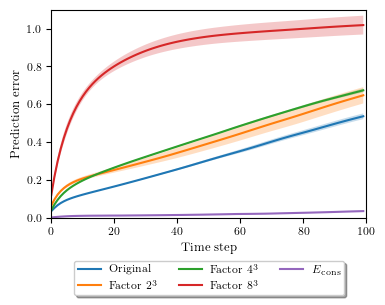

In [42]:
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6, aspect=0.8))

for sr, sub in across.groupby("sr"):
    x = sub["step"].values
    mu = sub["mu"].values
    sig = sub["sigma"].values
    plt.plot(x, mu, label=sr2label(sr))
    plt.fill_between(x, mu - sig, mu + sig, alpha=0.25)

ax.set_xlabel(r"Time step")
ax.set_ylabel(r"Prediction error")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0, top=1.1)
ax.set_xlim(left=0, right=100)
#ax.legend(frameon=True, loc="upper left")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),fancybox=True, shadow=True, ncol=3)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig("figures/superres_3d.pdf")